[View in Colaboratory](https://colab.research.google.com/github/sahilvora10/CIFAR-10/blob/master/CIFAR_10.ipynb)

# ** CIFAR - 10 **

We will classify  the CIFAR-10 dataset containing 60,000 images into 10 label classes.
We will use CNN using Keras over Tensorflow.

The next few blocks are to run Keras in Google Colab

In [1]:
!pip install -q keras
!pip install -q tqdm

#openCV is used to process and filter images
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17)

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
vcode = getpass.getpass()

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# print 'Files in Drive:'
!ls drive/

Here are few Libraries which are very important.

In [7]:
from __future__ import print_function, division

import keras as keras
import numpy as np
import random
import os
import glob
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from scipy.misc import imresize, imsave

from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**LOAD THE DATASET AND PREPROCESS IT.**

170500096/170498071 [==============================] - 30s 0us/step


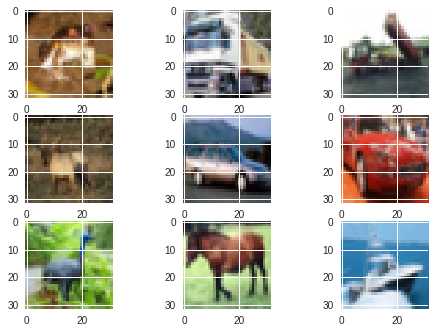

In [8]:
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(toimage(X_train[i]))
# show the plot
pyplot.show()

In [3]:
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [5]:
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 31s 0us/step


In [0]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [8]:
y_train.shape


(50000, 10)

In [9]:
num_classes

10

***BUILD FIRST MODEL AND COMPILE IT.***

In [10]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

***FIT THE MODEL***

In [11]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
39616/50000 [======================>.......] - ETA: 4s - loss: 1.7603 - acc: 0.3632

50000/50000 [==============================] - 24s 471us/step - loss: 1.7039 - acc: 0.3835 - val_loss: 1.3372 - val_acc: 0.5168
Epoch 2/25
50000/50000 [==============================] - 22s 441us/step - loss: 1.3209 - acc: 0.5247 - val_loss: 1.1916 - val_acc: 0.5759
Epoch 3/25
 1952/50000 [>.............................] - ETA: 20s - loss: 1.1381 - acc: 0.6055

50000/50000 [==============================] - 22s 439us/step - loss: 1.1477 - acc: 0.5903 - val_loss: 1.0703 - val_acc: 0.6186
Epoch 4/25
39296/50000 [======================>.......] - ETA: 4s - loss: 1.0246 - acc: 0.6345

50000/50000 [==============================] - 22s 440us/step - loss: 1.0198 - acc: 0.6360 - val_loss: 1.0133 - val_acc: 0.6398
Epoch 5/25
50000/50000 [==============================] - 22s 442us/step - loss: 0.9097 - acc: 0.6774 - val_loss: 0.9467 - val_acc: 0.6651
Epoch 6/25
 1920/50000 [>.............................] - ETA: 20s - loss: 0.8096 - acc: 0.7167

50000/50000 [==============================] - 22s 441us/step - loss: 0.8304 - acc: 0.7091 - val_loss: 0.9341 - val_acc: 0.6740
Epoch 7/25
39232/50000 [======================>.......] - ETA: 4s - loss: 0.7509 - acc: 0.7355

50000/50000 [==============================] - 22s 439us/step - loss: 0.7561 - acc: 0.7329 - val_loss: 0.9038 - val_acc: 0.6827
Epoch 8/25
50000/50000 [==============================] - 22s 439us/step - loss: 0.6869 - acc: 0.7564 - val_loss: 0.8932 - val_acc: 0.6868
Epoch 9/25
 1952/50000 [>.............................] - ETA: 19s - loss: 0.6222 - acc: 0.7751

50000/50000 [==============================] - 22s 444us/step - loss: 0.6260 - acc: 0.7765 - val_loss: 0.8957 - val_acc: 0.6907
Epoch 10/25
39136/50000 [======================>.......] - ETA: 4s - loss: 0.5725 - acc: 0.7983

50000/50000 [==============================] - 22s 440us/step - loss: 0.5768 - acc: 0.7958 - val_loss: 0.8984 - val_acc: 0.6992
Epoch 11/25
50000/50000 [==============================] - 22s 439us/step - loss: 0.5312 - acc: 0.8130 - val_loss: 0.9202 - val_acc: 0.6991
Epoch 12/25
 1824/50000 [>.............................] - ETA: 20s - loss: 0.4980 - acc: 0.8235

50000/50000 [==============================] - 22s 438us/step - loss: 0.4926 - acc: 0.8279 - val_loss: 0.9135 - val_acc: 0.7001
Epoch 13/25
39392/50000 [======================>.......] - ETA: 4s - loss: 0.4525 - acc: 0.8394

50000/50000 [==============================] - 22s 439us/step - loss: 0.4524 - acc: 0.8399 - val_loss: 0.9231 - val_acc: 0.7038
Epoch 14/25
50000/50000 [==============================] - 22s 438us/step - loss: 0.4181 - acc: 0.8529 - val_loss: 0.9290 - val_acc: 0.7030
Epoch 15/25
 1824/50000 [>.............................] - ETA: 20s - loss: 0.3800 - acc: 0.8783

50000/50000 [==============================] - 22s 438us/step - loss: 0.3874 - acc: 0.8646 - val_loss: 0.9440 - val_acc: 0.7072
Epoch 16/25
39040/50000 [======================>.......] - ETA: 4s - loss: 0.3589 - acc: 0.8752

50000/50000 [==============================] - 22s 441us/step - loss: 0.3604 - acc: 0.8738 - val_loss: 0.9664 - val_acc: 0.7026
Epoch 17/25
50000/50000 [==============================] - 22s 438us/step - loss: 0.3358 - acc: 0.8822 - val_loss: 0.9706 - val_acc: 0.7072
Epoch 18/25
 1824/50000 [>.............................] - ETA: 20s - loss: 0.2844 - acc: 0.9079

50000/50000 [==============================] - 22s 439us/step - loss: 0.3142 - acc: 0.8913 - val_loss: 0.9736 - val_acc: 0.7086
Epoch 19/25
39104/50000 [======================>.......] - ETA: 4s - loss: 0.3007 - acc: 0.8939

50000/50000 [==============================] - 22s 439us/step - loss: 0.2991 - acc: 0.8947 - val_loss: 1.0028 - val_acc: 0.7101
Epoch 20/25
50000/50000 [==============================] - 22s 439us/step - loss: 0.2823 - acc: 0.9017 - val_loss: 1.0085 - val_acc: 0.7070
Epoch 21/25
 1696/50000 [>.............................] - ETA: 20s - loss: 0.2568 - acc: 0.9098

50000/50000 [==============================] - 22s 440us/step - loss: 0.2619 - acc: 0.9084 - val_loss: 1.0180 - val_acc: 0.7054
Epoch 22/25
39008/50000 [======================>.......] - ETA: 4s - loss: 0.2493 - acc: 0.9142

50000/50000 [==============================] - 22s 440us/step - loss: 0.2513 - acc: 0.9133 - val_loss: 1.0321 - val_acc: 0.7074
Epoch 23/25
50000/50000 [==============================] - 22s 444us/step - loss: 0.2384 - acc: 0.9177 - val_loss: 1.0519 - val_acc: 0.7070
Epoch 24/25
 1568/50000 [..............................] - ETA: 20s - loss: 0.2468 - acc: 0.9101

50000/50000 [==============================] - 22s 439us/step - loss: 0.2259 - acc: 0.9218 - val_loss: 1.0714 - val_acc: 0.7098
Epoch 25/25
38944/50000 [======================>.......] - ETA: 4s - loss: 0.2121 - acc: 0.9278

50000/50000 [==============================] - 22s 438us/step - loss: 0.2152 - acc: 0.9261 - val_loss: 1.0530 - val_acc: 0.7092
Accuracy: 70.92%


*WE GOT AN ACCURACY of ~70%, this is not a good number.*

***WE BUILD ANOTHER MODEL ,THIS IS MORE DEEP AND WITH MORE LAYERS.***

In [81]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_27 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 64, 16, 16)        36928     
__________

We save each epoch value using the below code.

In [0]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

***FIT THE MODEL***

In [92]:
# Fit the model
modeldetais = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32,callbacks=[history])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 36s 716us/step - loss: 0.2444 - acc: 0.9127 - val_loss: 0.5570 - val_acc: 0.8234
Epoch 2/25
 6432/50000 [==>...........................] - ETA: 29s - loss: 0.2172 - acc: 0.9206

50000/50000 [==============================] - 36s 713us/step - loss: 0.2403 - acc: 0.9132 - val_loss: 0.5554 - val_acc: 0.8250
Epoch 3/25
24128/50000 [=============>................] - ETA: 17s - loss: 0.2279 - acc: 0.9185

50000/50000 [==============================] - 36s 713us/step - loss: 0.2320 - acc: 0.9168 - val_loss: 0.5535 - val_acc: 0.8258
Epoch 4/25
31232/50000 [=================>............] - ETA: 12s - loss: 0.2208 - acc: 0.9190

50000/50000 [==============================] - 36s 723us/step - loss: 0.2238 - acc: 0.9178 - val_loss: 0.5512 - val_acc: 0.8263
Epoch 5/25
33376/50000 [===================>..........] - ETA: 11s - loss: 0.2183 - acc: 0.9217

50000/50000 [==============================] - 36s 723us/step - loss: 0.2210 - acc: 0.9206 - val_loss: 0.5750 - val_acc: 0.8250
Epoch 6/25
33728/50000 [===================>..........] - ETA: 11s - loss: 0.2114 - acc: 0.9243

50000/50000 [==============================] - 37s 730us/step - loss: 0.2112 - acc: 0.9239 - val_loss: 0.5689 - val_acc: 0.8266
Epoch 7/25
33568/50000 [===================>..........] - ETA: 11s - loss: 0.2035 - acc: 0.9263

50000/50000 [==============================] - 36s 729us/step - loss: 0.2070 - acc: 0.9256 - val_loss: 0.5695 - val_acc: 0.8267
Epoch 8/25
34048/50000 [===================>..........] - ETA: 11s - loss: 0.2010 - acc: 0.9287

50000/50000 [==============================] - 36s 730us/step - loss: 0.2020 - acc: 0.9276 - val_loss: 0.5758 - val_acc: 0.8274
Epoch 9/25
34976/50000 [===================>..........] - ETA: 10s - loss: 0.1907 - acc: 0.9320

50000/50000 [==============================] - 36s 729us/step - loss: 0.1930 - acc: 0.9311 - val_loss: 0.5812 - val_acc: 0.8282
Epoch 10/25
34272/50000 [===================>..........] - ETA: 10s - loss: 0.1886 - acc: 0.9321

50000/50000 [==============================] - 36s 726us/step - loss: 0.1903 - acc: 0.9321 - val_loss: 0.5845 - val_acc: 0.8284
Epoch 11/25
33632/50000 [===================>..........] - ETA: 11s - loss: 0.1841 - acc: 0.9326

50000/50000 [==============================] - 37s 730us/step - loss: 0.1873 - acc: 0.9314 - val_loss: 0.5689 - val_acc: 0.8300
Epoch 12/25
33344/50000 [===================>..........] - ETA: 11s - loss: 0.1794 - acc: 0.9349

50000/50000 [==============================] - 37s 733us/step - loss: 0.1815 - acc: 0.9341 - val_loss: 0.5822 - val_acc: 0.8263
Epoch 13/25
33824/50000 [===================>..........] - ETA: 11s - loss: 0.1718 - acc: 0.9380

50000/50000 [==============================] - 37s 732us/step - loss: 0.1746 - acc: 0.9373 - val_loss: 0.5781 - val_acc: 0.8301
Epoch 14/25
34240/50000 [===================>..........] - ETA: 11s - loss: 0.1764 - acc: 0.9357

50000/50000 [==============================] - 37s 736us/step - loss: 0.1760 - acc: 0.9359 - val_loss: 0.5860 - val_acc: 0.8291
Epoch 15/25
33376/50000 [===================>..........] - ETA: 11s - loss: 0.1670 - acc: 0.9397

50000/50000 [==============================] - 37s 731us/step - loss: 0.1680 - acc: 0.9396 - val_loss: 0.5935 - val_acc: 0.8298
Epoch 16/25
33600/50000 [===================>..........] - ETA: 11s - loss: 0.1593 - acc: 0.9427

50000/50000 [==============================] - 36s 727us/step - loss: 0.1629 - acc: 0.9417 - val_loss: 0.5917 - val_acc: 0.8288
Epoch 17/25
33952/50000 [===================>..........] - ETA: 11s - loss: 0.1628 - acc: 0.9409

50000/50000 [==============================] - 36s 726us/step - loss: 0.1628 - acc: 0.9413 - val_loss: 0.5995 - val_acc: 0.8303
Epoch 18/25
34912/50000 [===================>..........] - ETA: 10s - loss: 0.1578 - acc: 0.9416

50000/50000 [==============================] - 36s 724us/step - loss: 0.1561 - acc: 0.9426 - val_loss: 0.6064 - val_acc: 0.8280
Epoch 19/25
34656/50000 [===================>..........] - ETA: 10s - loss: 0.1540 - acc: 0.9441

50000/50000 [==============================] - 36s 723us/step - loss: 0.1531 - acc: 0.9444 - val_loss: 0.6038 - val_acc: 0.8311
Epoch 20/25
34912/50000 [===================>..........] - ETA: 10s - loss: 0.1555 - acc: 0.9438

50000/50000 [==============================] - 36s 721us/step - loss: 0.1551 - acc: 0.9440 - val_loss: 0.6054 - val_acc: 0.8290
Epoch 21/25
34880/50000 [===================>..........] - ETA: 10s - loss: 0.1423 - acc: 0.9491

50000/50000 [==============================] - 37s 738us/step - loss: 0.1441 - acc: 0.9491 - val_loss: 0.6033 - val_acc: 0.8314
Epoch 22/25
35136/50000 [====================>.........] - ETA: 10s - loss: 0.1418 - acc: 0.9483

50000/50000 [==============================] - 38s 752us/step - loss: 0.1431 - acc: 0.9477 - val_loss: 0.6107 - val_acc: 0.8319
Epoch 23/25
24000/50000 [=============>................] - ETA: 24s - loss: 0.1424 - acc: 0.9503

50000/50000 [==============================] - 50s 1ms/step - loss: 0.1411 - acc: 0.9500 - val_loss: 0.6178 - val_acc: 0.8318
Epoch 24/25
18400/50000 [==========>...................] - ETA: 30s - loss: 0.1393 - acc: 0.9508

50000/50000 [==============================] - 52s 1ms/step - loss: 0.1396 - acc: 0.9510 - val_loss: 0.6171 - val_acc: 0.8321
Epoch 25/25
15840/50000 [========>.....................] - ETA: 34s - loss: 0.1341 - acc: 0.9525

50000/50000 [==============================] - 53s 1ms/step - loss: 0.1362 - acc: 0.9514 - val_loss: 0.6246 - val_acc: 0.8318
Accuracy: 83.18%


***WE GOT AN ACCURACY OF ~83% which is really good number,but we also want more epochs to get an higher accuracy.***

In [0]:
import matplotlib.pyplot as plt

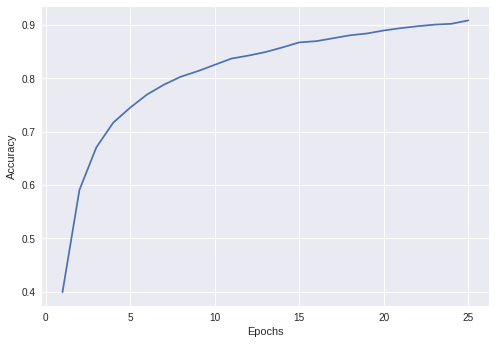

In [88]:
plt.plot(range(1,26), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [96]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving helper.py to helper.py


In [0]:
from helper import get_class_names, get_train_data, get_test_data, plot_images
from helper import plot_model, predict_classes, visualize_errors

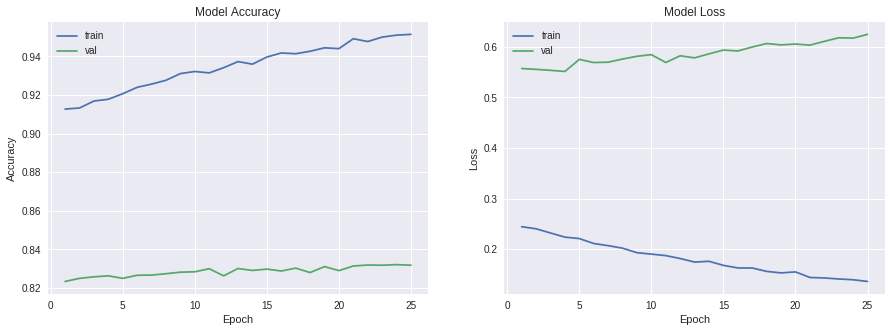

In [99]:
plot_model(modeldetais)